In [11]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.10.1
sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)
matplotlib 3.5.3
numpy 1.23.2
pandas 1.5.1
sklearn 1.1.3
tensorflow 2.10.1
keras.api._v2.keras 2.10.0


In [12]:
train_dir = "./input/corn_leaf/train"
valid_dir = "./input/corn_leaf/valid"
test_dir = "./input/corn_leaf/test"
label_file = "./input/corn_leaf/corn_leaf_labels.txt"
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))

print(os.listdir(train_dir))
print(os.listdir(valid_dir))



True
True
True
['dabanbing', 'healthy', 'huibanbing', 'wanbaoyebanbing', 'xiubing', 'yuanbanbing']
['dabanbing', 'healthy', 'huibanbing', 'wanbaoyebanbing', 'xiubing', 'yuanbanbing']


In [13]:
labels = pd.read_csv(label_file, header=0)
print(labels)

             Label
0        dabanbing
1          healthy
2       huibanbing
3  wanbaoyebanbing
4          xiubing
5      yuanbanbing


In [14]:
height = 224
width = 224
channels = 3
batch_size = 64
num_classes = 6

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 7,
                                                    shuffle = False,
                                                    class_mode = "categorical")


# #对验证集必须做一个值的缩放，其他的不需要做
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 7,
                                                    shuffle = False,
                                                    class_mode = "categorical")
train_num = train_generator.samples

valid_num = valid_generator.samples
print(train_num, valid_num)

Found 2500 images belonging to 6 classes.
Found 716 images belonging to 6 classes.
2500 716


In [15]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)


(64, 224, 224, 3) (64, 6)
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 

In [16]:
resnet50_fine_tune = keras.models.Sequential()
#resnet有1000个分类，我们只有10类，最后一层要去掉，最后的输出是三维矩阵，而不是一维的，
# 我们通过pooling = 'avg'解决这个问题
# pooling size 是（2，2）的时候是大小减半，而pooling size恰好等于图像大小的时候，就可以降维。
resnet50_fine_tune.add(keras.applications.ResNet50(include_top = False,
                                                   pooling = 'avg',
                #weights = 'imagenet'就会下载imagenet，在这个初始化好的基础上去训练
                                                   weights = 'imagenet'))
#加一个全连接层num_classes值为6，相当于只调整最后的参数
resnet50_fine_tune.add(keras.layers.Dense(num_classes, activation = 'softmax'))
print(resnet50_fine_tune.layers)
resnet50_fine_tune.layers[0].trainable = False



[<keras.engine.functional.Functional object at 0x00000190E4439460>, <keras.layers.core.dense.Dense object at 0x0000018F6CEDC6A0>]


In [17]:
# 各种尺度度量
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

resnet50_fine_tune.compile(loss="categorical_crossentropy",
              optimizer="sgd", metrics=['accuracy',METRICS],
              )
resnet50_fine_tune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
len(resnet50_fine_tune.layers)

2

In [19]:
from keras.utils import plot_model
plot_model(resnet50_fine_tune)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
epochs = 30

# 保存训练中的模型
checkpoint_path = "./training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history1 = resnet50_fine_tune.fit(train_generator,
                    #显试指定
                    steps_per_epoch = train_num // batch_size,
                    epochs = epochs,
                    validation_data = valid_generator,
                    validation_steps = valid_num // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/30
39/39 [==============================] - ETA: 0s - loss: 2.6483 - accuracy: 0.5304 - tp: 1261.0000 - fp: 1074.0000 - tn: 11106.0000 - fn: 1175.0000 - precision: 0.5400 - recall: 0.5177 - auc: 0.8012

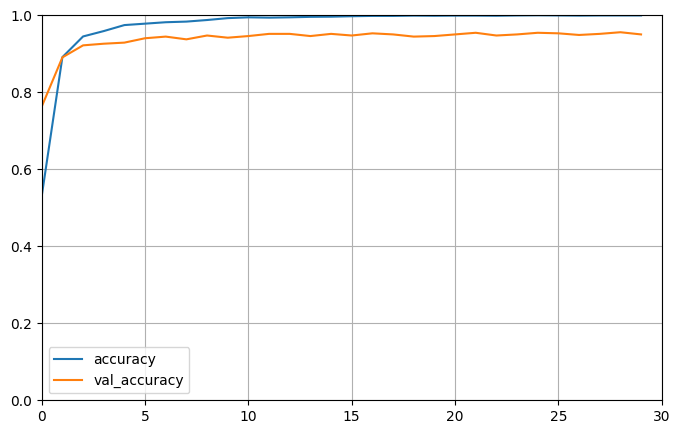

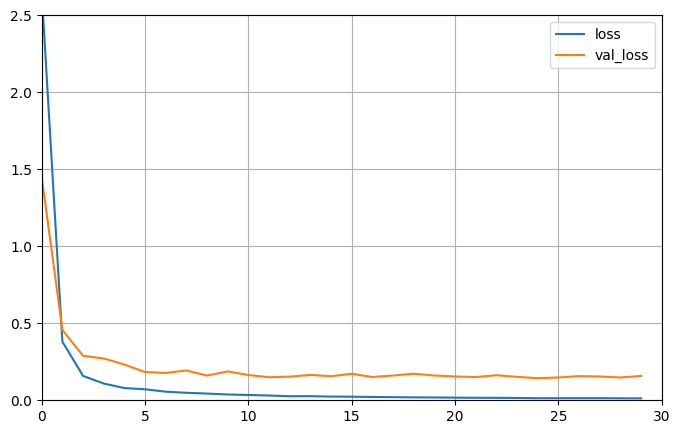

In [21]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
#因为accuracy的值和loss值的范围很不一样，因此我们打印两条曲线
plot_learning_curves(history1, 'accuracy', epochs, 0, 1)
plot_learning_curves(history1, 'loss', epochs, 0, 2.5)


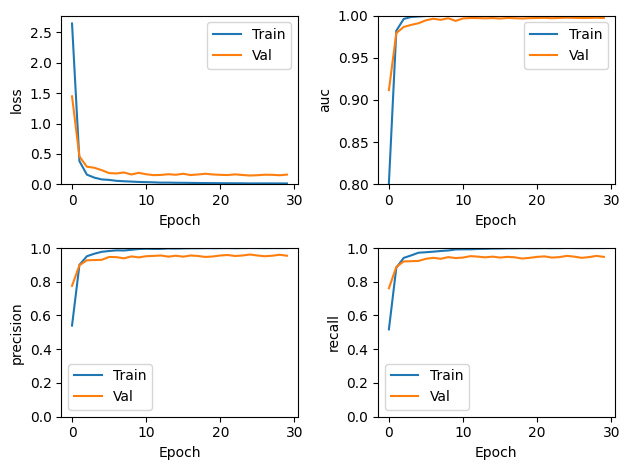

In [22]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric],label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
        plt.tight_layout()
plot_metrics(history1)

In [23]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input)
test_generator = valid_datagen.flow_from_directory(test_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 7,
                                                    shuffle = False,
                                                    class_mode = "categorical")
test_num = test_generator.samples

Found 120 images belonging to 6 classes.


In [24]:
from PIL import Image
def load_preprocess_image(filename_path):
    img = tf.io.read_file(filename_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(images=img, size=(224,224))
    img_array = np.array(img, dtype=np.float32)
    image = np.expand_dims(img_array, axis=0)
    datagen = keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function = keras.applications.resnet50.preprocess_input)
    my_generator = datagen.flow(image,
                                batch_size = 1,
                                )
    return my_generator

def prediction_classes():
    dirs = os.listdir('./input/corn_leaf/test')
    print(dirs)
    for classes in dirs:
        classes_pathname = os.path.join('./input/corn_leaf/test',classes)
        count = 0
        for filepath, dirnames, filenames in os.walk(classes_pathname):
            for filename in filenames:
                filename_path = os.path.join(filepath, filename)
                my_generator = load_preprocess_image(filename_path)
                prediction = resnet50_fine_tune.predict(my_generator)
                num=['dabanbing','healthy','huibanbing','wanbaoyebanbing','xiubing','yuanbanbing']
                print ("This is a %s"%(num[int(np.argmax(prediction, axis=1))]))
                if classes == num[int(np.argmax(prediction, axis=1))]:
                    count+=1
            print(count)
            print('{}准确率为：{:.2f}%'.format(classes,count/20*100))


prediction_classes()


['dabanbing', 'healthy', 'huibanbing', 'wanbaoyebanbing', 'xiubing', 'yuanbanbing']
1/1 [==============================] - 1s 551ms/step
This is a dabanbing
1/1 [==============================] - 0s 30ms/step
This is a dabanbing
1/1 [==============================] - 0s 31ms/step
This is a dabanbing
1/1 [==============================] - 0s 30ms/step
This is a dabanbing
1/1 [==============================] - 0s 30ms/step
This is a dabanbing
1/1 [==============================] - 0s 25ms/step
This is a dabanbing
1/1 [==============================] - 0s 30ms/step
This is a dabanbing
1/1 [==============================] - 0s 30ms/step
This is a dabanbing
1/1 [=======

In [25]:
count = 0
def Accuracy(predict_array,true_classes,count):
    num=['dabanbing','healthy','huibanbing','wanbaoyebanbing','xiubing','yuanbanbing']
    for j in predict_array:
        classes = num[int(np.argmax(j))]
        if classes == num[true_classes]:
            count += 1
    print('{}的准确率为：{}%'.format(num[true_classes],count/20*100))

test_predict = resnet50_fine_tune.predict(test_generator)
# print(test_predict)
# print(test_predict.shape)
# print(type(test_predict))
predict_dabanbing = test_predict[:20]
Accuracy(predict_dabanbing,0,count)
predict_healthy = test_predict[20:40]
Accuracy(predict_healthy,1,count)
predict_huibanbing = test_predict[40:60]
Accuracy(predict_huibanbing,2,count)
predict_wanbaoyebanbing = test_predict[60:80]
Accuracy(predict_wanbaoyebanbing,3,count)
predict_xiubing = test_predict[80:100]
Accuracy(predict_xiubing,4,count)
predict_yuanbanbing = test_predict[100:120]
Accuracy(predict_yuanbanbing,5,count)

2/2 [==============================] - 3s 1s/step
dabanbing的准确率为：100.0%
healthy的准确率为：100.0%
huibanbing的准确率为：95.0%
wanbaoyebanbing的准确率为：100.0%
xiubing的准确率为：100.0%
yuanbanbing的准确率为：100.0%


In [26]:
resnet50_fine_tune.save('./saved_model/my_model2')


INFO:tensorflow:Assets written to: ./saved_model/my_model2\assets


INFO:tensorflow:Assets written to: ./saved_model/my_model2\assets
